In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from models import ValueIterationNetwork, GridWorldNode, SRResampler
from models.utils import softmax, one_hot
from models.sr import get_optimal_sr_from_transitions, get_value_function_from_sr
from environments.thread_the_needle import make_thread_the_needle, make_thread_the_needle_walls_moved_door
import environments.thread_the_needle as e


# Simulation 1: Change in transition matrix
Idea here is to calculate the computational cost, in resampling uniformly the transitions

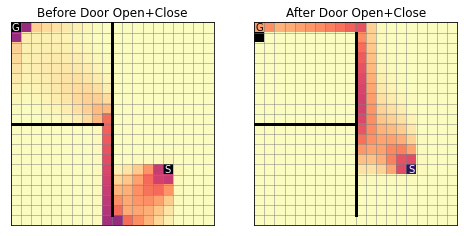

In [2]:
# define the enviornments
n_rows, n_columns = 20, 20
start_state = n_rows * n_columns - n_columns//2 + n_columns//4  - n_columns*(n_rows//4)

transition_functions_pre, state_reward_function, optimal_policy_pre = make_thread_the_needle(
    n_rows=n_rows,
    n_columns=n_columns,
    movement_penalty=0.01,
    slip_probability=0.05,
    random_movement_on_error=False,
    sparse=False,
)

transition_functions_post, _, _ = make_thread_the_needle(
    n_rows=n_rows,
    n_columns=n_columns,
    movement_penalty=0.01,
    slip_probability=0.05,
    random_movement_on_error=False,
    list_walls = make_thread_the_needle_walls_moved_door(n_columns),
    sparse=False,
)
optimal_policy_post = e.make_thread_the_needle_with_doors_optimal_policy(n_rows, n_columns)


# estimate the SR
gamma = 0.95
sr_kwargs = dict( gamma=gamma)

M = get_optimal_sr_from_transitions(transition_functions_pre, optimal_policy_pre, **sr_kwargs)
M_post = get_optimal_sr_from_transitions(transition_functions_post, optimal_policy_post, **sr_kwargs)


# plot

fig, axes = plt.subplots(1, 2, figsize=(8, 4))    

axes[0].imshow(M[start_state,].reshape(20 ,20), origin='upper',  cmap='magma_r')
e.clean_up_thread_the_needle_plot(axes[0], n_rows, n_columns)
axes[0].annotate('G', (0, 0), ha='center', va='center', c='w')
axes[0].annotate('S', (n_rows-5, n_columns-6), ha='center', va='center', c='w')


axes[1].imshow(M_post[start_state,].reshape(20 ,20), origin='upper', cmap='magma_r')
walls = e.make_thread_the_needle_walls_moved_door(n_columns)
e.clean_up_thread_the_needle_plot(axes[1], n_rows, n_columns, walls=walls)
axes[1].annotate('G', (0, 0), ha='center', va='center', c='k')
axes[1].annotate('S', (n_rows-5, n_columns-6), ha='center', va='center', c='w')

axes[0].set_title('Before Door Open+Close')
axes[1].set_title('After Door Open+Close')

plt.savefig('images/SuccessorRepresentation_transition_change.png', dpi=300)

In [3]:
# first room states
from sklearn.metrics.pairwise import cosine_similarity
d = cosine_similarity(optimal_policy_pre, optimal_policy_post)
np.diag(d).mean()

0.5812652416360247

In [4]:
d = cosine_similarity(M.reshape(1, -1), M_post.reshape(1, -1))
d

array([[0.37384379]])

In [5]:
V_pre = get_value_function_from_sr(M, state_reward_function)
V_post = get_value_function_from_sr(M_post, state_reward_function)

d = cosine_similarity(V_pre.reshape(1, -1), V_post.reshape(1, -1))
d

array([[0.80455345]])

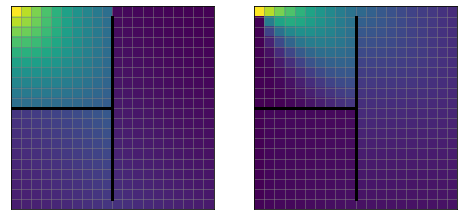

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(V_pre.reshape(20, 20))
axes[1].imshow(V_post.reshape(20, 20))
e.clean_up_thread_the_needle_plot(axes[0], n_rows, n_columns, walls=walls)
e.clean_up_thread_the_needle_plot(axes[1], n_rows, n_columns, walls=walls)



# change to reward function

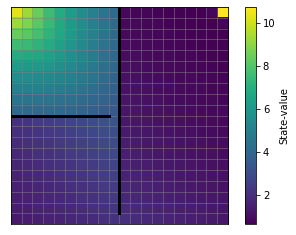

In [7]:
rew_2 = state_reward_function.copy()
rew_2[0] = 1
rew_2[20 - 1] = 10

plt.imshow(M.dot(rew_2).reshape(20, 20))
e.clean_up_thread_the_needle_plot(plt.gca(), n_rows, n_columns)
plt.colorbar(label='State-value')
plt.savefig('images/reward_revaluation.png', dpi=300)



## Resampling

In [8]:
#Start with reward replanning

learning_rate = 0.5

softmax_temperature = 10.0

sr = SRResampler(
    learning_rate=learning_rate,
    gamma=gamma,
    transition_functions=transition_functions_pre,
    state_reward_function=rew_2,
    beta=softmax_temperature,
    n_rows=n_rows,
    n_columns=n_columns
)

initial_q_values = SRResampler.get_q_values(
    transition_functions_pre,
    M,
    state_reward_function,
    gamma,
)

np.mean([cosine_similarity(sr._one_sample_update(M, rew_2).reshape(1, -1),
                           M.reshape(1, -1)) for _ in range(1000)])

0.9999816645110993

  0%|          | 0/1000 [00:00<?, ?it/s]

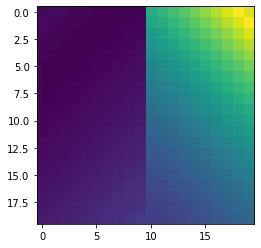

In [9]:
optimal_value_function = sr._calculate_optimal_value_function()
plt.imshow(optimal_value_function.reshape(20,20))

In [10]:
np.mean([cosine_similarity(sr._one_sample_update(M, optimal_value_function).reshape(1, -1),
                           M.reshape(1, -1)) for _ in range(1000)])

0.9999771256944084

Resampling: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:08<00:00,  3.89it/s]


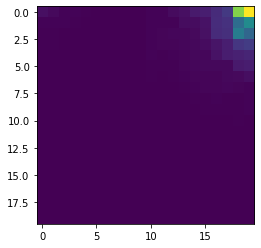

In [11]:
M_resampled = sr.resample(M, state_values=np.ones_like(optimal_value_function),
                          restimate_state_values=False, steps=500)

plt.imshow(get_value_function_from_sr(M_resampled, rew_2).reshape(20,20))

Resampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.22it/s]


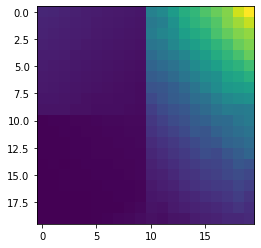

In [12]:
M_resampled = sr.resample(M, restimate_state_values=True, steps=25)

plt.imshow(get_value_function_from_sr(M_resampled, rew_2).reshape(20,20))

In [13]:
d = cosine_similarity(get_value_function_from_sr(M_resampled, rew_2).reshape(1, -1), optimal_value_function.reshape(1, -1))
d

array([[0.96221113]])

In [14]:
initial_state = 15
sampled_action = sr._sample_action_from_value_function(initial_state, optimal_value_function)
sampled_successor_state = sr._sample_successor_state(initial_state, sampled_action)
print((initial_state, sampled_action, sampled_successor_state))

np.max(sr._delta_update(initial_state, sampled_successor_state, M) - M
)

(15, 2, 16)


0.47685254273358957

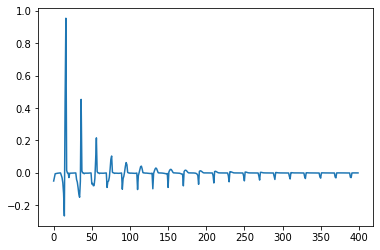

In [15]:
plt.plot(one_hot(initial_state, sr.n_states) + sr.gamma * M[sampled_successor_state, :] - M[initial_state])

In [16]:
import random
random.sample(range(10), 10)

[1, 2, 9, 3, 8, 7, 0, 6, 4, 5]

In [17]:
np.max([np.max(sr._one_sample_update(M, optimal_value_function) - M) for _ in range(1000)])

0.9216633164517959

# Simulation 2: Policy Re-evaluation 


In [18]:
# 1-D state-space with 20 states.  Start at state 4, goal at 0 (+1), loss at 8, (-1)
# optimal policy: left with 100%
# assume epsilon slip probability, so
# T(s, s') = s-1 with probability 1-epsilon


n_states = 20
start_state = n_states // 2 + 1
epsilon = 0.05


T_left = np.diag(np.ones(n_states-1), k=-1) * (1 - epsilon) \
    + np.diag(np.ones(n_states-1), k=1) * epsilon
# make the goal states terminal
T_left[0,0] = 1
T_left[0, 1:] = 0
T_left[-1, -1] = 1
T_left[-1, :-1] = 0

T_right = np.diag(np.ones(n_states-1), k=1) * (1 - epsilon) \
    + np.diag(np.ones(n_states-1), k=-1) * epsilon
# make the goal states terminal
T_right[0,0] = 1
T_right[0, 1:] = 0
T_right[-1, -1] = 1
T_right[-1, :-1] = 0


# optimal policy is always to go left
T_pi = np.copy(T_left)
T_df = np.copy(T_left + T_right) / 2

([<matplotlib.axis.YTick at 0x7f92c12902e0>,
 [Text(0, 4, '5'), Text(0, 9, '10'), Text(0, 14, '15'), Text(0, 19, '20')])

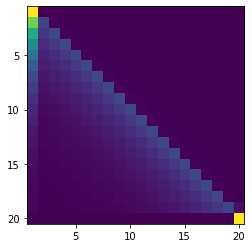

In [19]:
# eqn 12 in Russek 2017

gamma = 0.8

M = np.linalg.inv(np.eye(n_states) - gamma * T_pi)
plt.imshow(M)
plt.xticks([ii for ii in range(4, 21, 5)], labels=[ii for ii in range(5, 21, 5)])
plt.yticks([ii for ii in range(4, 21, 5)], labels=[ii for ii in range(5, 21, 5)])


Text(0, 0.5, 'State-Values')

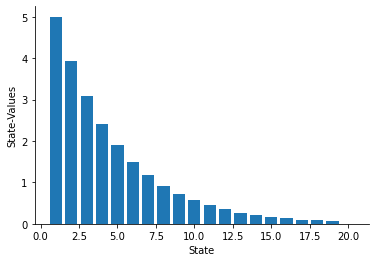

In [20]:
R = np.zeros(n_states)
R[0] = 1
R[-1] = 0

# equation 6, Gershman J Neuro 2018
V = M.dot(R.reshape(-1, 1))
plt.bar(x=np.arange(1, n_states + 1), height=V.reshape(-1))
sns.despine()
# plt.xticks(np.arange(1, n_states + 1))
plt.xlabel('State')
plt.ylabel('State-Values')

In [21]:
# This model is my own.  One step look-ahead Q-values where
# Q(s, a) = T(s, a, s')V(s')
# with a policy
# pi(s) ~ softmax[Q(s, a)]

beta = 10.

V = SR.get_value_function(M, R)
Q_values = SR.get_q_values([T_left, T_right], M, R, gamma=1)
Q_left, Q_right = Q_values
pi_correct_pre = np.exp(Q_left*beta) / (np.exp(Q_left*beta) + np.exp(Q_right*beta))
plt.plot(np.arange(2, n_states ), pi_correct_pre[1:-1], label='Optimal SR')

# plot the diffusion SR
M_df = np.linalg.inv(np.eye(n_states) - gamma * T_df)
V_df = SR.get_value_function(M_df, R)
Q_values_diffusion = SR.get_q_values([T_left, T_right], M_df, R, gamma=1)
Q_left_df, Q_right_df = Q_values_diffusion
pi_diff_pre = np.exp(Q_left_df*beta) / (np.exp(Q_left_df*beta) + np.exp(Q_right_df*beta))
plt.plot(np.arange(2, n_states ), pi_diff_pre[1:-1], label='Diffusion SR')

plt.plot(np.arange(2, n_states), np.ones(n_states-2) * 0.5, 'k:', label='chance')

plt.legend()
sns.despine()

NameError: name 'SR' is not defined

In [ ]:
plt.plot(V)
plt.plot(V_df)

In [ ]:
# policy
# pi(s, a) = softmax(Q(s,a))

pi_correct_pre = np.exp(Q_left*beta) / (np.exp(Q_left*beta) + np.exp(Q_right*beta))
plt.plot(np.arange(2, n_states ), pi_correct_pre[1:-1], label='Optimal SR')

# plot the same thing but with the diffusion SR
M_df = np.linalg.inv(np.eye(n_states) - gamma * T_df)
V = M_df.dot(R.reshape(-1, 1))
Q_left = T_left.dot(V).reshape(-1)
Q_right = T_right.dot(V).reshape(-1)
pi_diff_pre = np.exp(Q_left*beta) / (np.exp(Q_left*beta) + np.exp(Q_right*beta))
plt.plot(np.arange(2, n_states ), pi_diff_pre[1:-1], label='Diffusion SR')

plt.legend()
sns.despine()

In [ ]:
M_df.shape

In [ ]:

R = np.zeros(9)
R[0] = 1
R[-1] = 2

# equation 6, Gershman J Neuro 2018
V = M.dot(R.reshape(-1, 1))
plt.bar(x=np.arange(1, 10), height=V.reshape(-1))
sns.despine()
plt.xticks(np.arange(1, 10))
plt.xlabel('State')
plt.ylabel('State-Values')

In [ ]:
V = M.dot(R.reshape(-1, 1))

# This model is my own.  One step look-ahead Q-values where
# Q(s, a) = T(s, a, s')V(s')

Q_left = T_left.dot(V).reshape(-1)
Q_right = T_right.dot(V).reshape(-1)

df = {
    'State': np.concatenate([np.arange(1, 10), np.arange(1, 10)]),
    'Q-value': np.concatenate([Q_left, Q_right]),
    'Action': ['Left'] * 9 + ['Right'] * 9
}


sns.barplot(x='State',y='Q-value', data=pd.DataFrame(df), hue='Action', palette='Set2')
sns.despine()

In [ ]:
# policy
# pi(s, a) = softmax(Q(s,a))
pi_correct_post = np.exp(Q_left) / (np.exp(Q_left) + np.exp(Q_right))
plt.bar(np.arange(2, 9), pi_correct_pre[1:-1])
plt.bar(np.arange(2, 9), pi_correct_post[1:-1])
plt.xlabel('Probablity of Left')
plt.ylabel('State')
sns.despine()

In [ ]:
# V = M.dot(R.reshape(-1, 1))
T_left.dot(V)

df = {
    'State': np.concatenate([np.arange(1, 10), np.arange(1, 10)]),
    'Q-value': np.concatenate([T_left.dot(V).reshape(-1), T_right.dot(V).reshape(-1)]),
    'Action': ['Left'] * 9 + ['Right'] * 9
}


sns.barplot(x='State',y='Q-value', data=pd.DataFrame(df), hue='Action', palette='Set2')
sns.despine()

In [ ]:
plt.plot((T_right + T_left).dot(V)
)


In [ ]:
M_df = np.linalg.inv(np.eye(9) - gamma * T_df)
V = M_df.dot(R.reshape(-1, 1))


plt.bar(x=np.arange(1, 10), height=V.reshape(-1))
sns.despine()
plt.xticks(np.arange(1, 10))
plt.xlabel('State')
plt.ylabel('State-Values')
plt.title('Diffusion policy')

In [ ]:
state_action_reward_functions = environments.get_state_action_reward_from_sucessor_rewards(
    R, [T_left, T_right]
)

sa_values, s_values = ValueIterationNetwork.value_iteration(
    [T_left, T_right], state_action_reward_functions, n_rows=1, n_columns=n_states, gamma=gamma)
s_values

In [ ]:
s_values

In [ ]:
plt.plot(V.reshape(-1))
plt.plot(s_values, )

In [ ]:
sa_values